In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [4]:
#unzipping

import zipfile

z= zipfile.ZipFile('/content/archive (8).zip')
z.extractall()

In [5]:
data_dir = '/content/brain_tumor_dataset'  # Change this if needed
categories = ['no', 'yes']  # no = no tumor, yes = tumor

data = []

IMG_SIZE = 150

for category in categories:
    folder = os.path.join(data_dir, category)
    label = categories.index(category)

    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append([img, label])
        except:
            pass


In [6]:
random.shuffle(data)

X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0  # Normalize
y = np.array(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# EDA, how many images available in Y, N files
yeslist= os.listdir("brain_tumor_dataset/yes/")

number_files_yes= len(yeslist)
print(number_files_yes)

nolist= os.listdir("brain_tumor_dataset/no/")
number_files_no= len(nolist)
print(number_files_no)

155
98


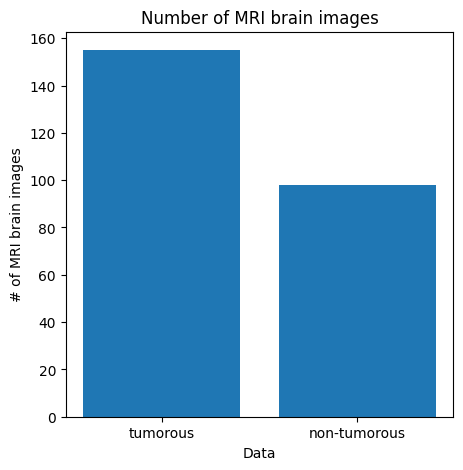

In [28]:
#plotting

data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}
typex= data.keys()
values= data.values()
fig = plt.figure(figsize = (5, 5))

plt.bar(typex, values)
plt.xlabel('Data')
plt.ylabel('# of MRI brain images')
plt.title('Number of MRI brain images')
plt.show()


#**Adding Augmented Data**




In [56]:
tumor_dir = os.path.join(data_dir, 'yes')
no_tumor_dir = os.path.join(data_dir, 'no')


In [57]:
def load_images_from_folder(folder, count):
    images = []
    for i, filename in enumerate(os.listdir(folder)):
        if i >= count:
            break
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images


In [59]:
tumor_images = load_images_from_folder(tumor_dir, 5)
no_tumor_images = load_images_from_folder(no_tumor_dir, 5)


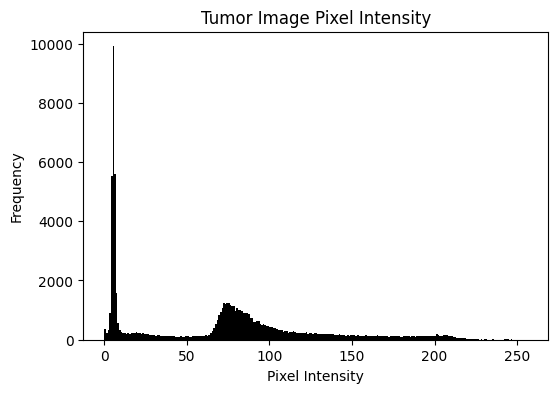

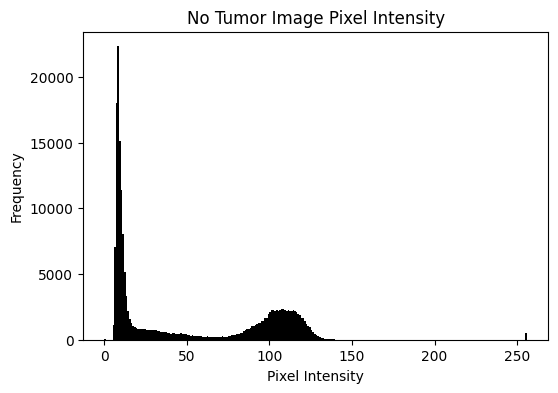

In [60]:
plot_histograms(tumor_images[0], "Tumor Image Pixel Intensity")
plot_histograms(no_tumor_images[0], "No Tumor Image Pixel Intensity")


In [46]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        brightness_range=(0.3, 1.0),
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1, ) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i = 0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,
                                   save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break


In [47]:
def timing(sec_elapsed):
  h= int(sec_elapsed/ (60*60))
  m= int((sec_elapsed % (60*60))/60)
  s= sec_elapsed % 60

  return f"{h}:{m}:{round(s,1)}"


In [48]:
import time
start_time=time.time()

yes_path= 'brain_tumor_dataset/yes'
no_path='brain_tumor_dataset/no'

augmented_data_path= 'augmented_data/'

import os

augmented_data_path = 'augmented_data/'

# Make sure directories exist
os.makedirs(os.path.join(augmented_data_path, 'yes'), exist_ok=True)
os.makedirs(os.path.join(augmented_data_path, 'no'), exist_ok=True)

augmented_data(file_dir= yes_path, n_generated_samples=6, save_to_dir= augmented_data_path+'yes')
augmented_data(file_dir= no_path, n_generated_samples=9, save_to_dir= augmented_data_path+'no')

end_time= time.time()
execution_time= (end_time-start_time)
print(f"Elapsed time: {timing(execution_time)}")

Elapsed time: 0:1:42.6


In [23]:
def data_summary(main_path):
    yes_path = os.path.join(main_path, 'yes')
    no_path = os.path.join(main_path, 'no')

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))
    n = n_pos + n_neg

    pos_per = (n_pos * 100) / n
    neg_per = (n_neg * 100) / n

    print(f"Total number of samples: {n}")
    print(f"Positive samples: {n_pos}, ({pos_per:.2f}%)")
    print(f"Negative samples: {n_neg}, ({neg_per:.2f}%)")


In [32]:
data_summary(augmented_data_path)

Total number of samples: 2065
Positive samples: 1085, (52.54%)
Negative samples: 980, (47.46%)


# **Data** **Augmentation**

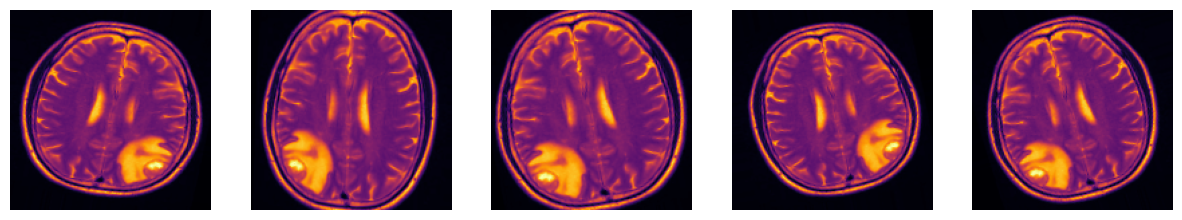

In [63]:
#augmentation data (tumor)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, horizontal_flip=True)

# Resize first
img = cv2.resize(tumor_images[0], (IMG_SIZE, IMG_SIZE))
img = img.reshape((IMG_SIZE, IMG_SIZE, 1))
img = img.astype('float32') / 255.0
img = img.reshape((1, IMG_SIZE, IMG_SIZE, 1))

aug_iter = datagen.flow(img)

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    batch = next(aug_iter)
    axs[i].imshow(batch[0].reshape(IMG_SIZE, IMG_SIZE), cmap='inferno')
    axs[i].axis('off')
plt.show()



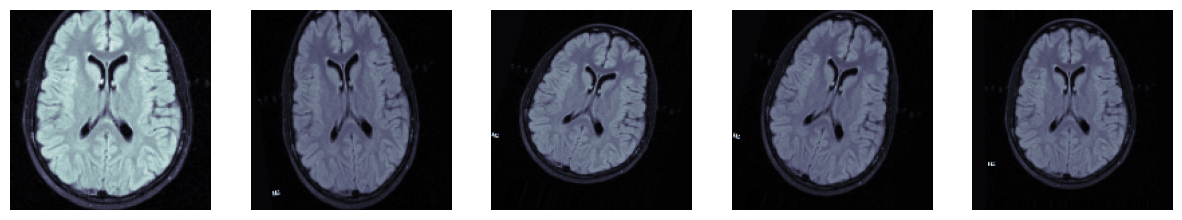

In [66]:
#augmentation data (no tumors)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, horizontal_flip=True)

# Resize before reshaping
img = cv2.resize(no_tumor_images[0], (IMG_SIZE, IMG_SIZE))
img = img.reshape((IMG_SIZE, IMG_SIZE, 1))
img = img.astype('float32') / 255.0
img = img.reshape((1, IMG_SIZE, IMG_SIZE, 1))

aug_iter = datagen.flow(img)

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    batch = next(aug_iter)
    axs[i].imshow(batch[0].reshape(IMG_SIZE, IMG_SIZE), cmap='bone')
    axs[i].axis('off')
plt.show()


# **Data Visualization**

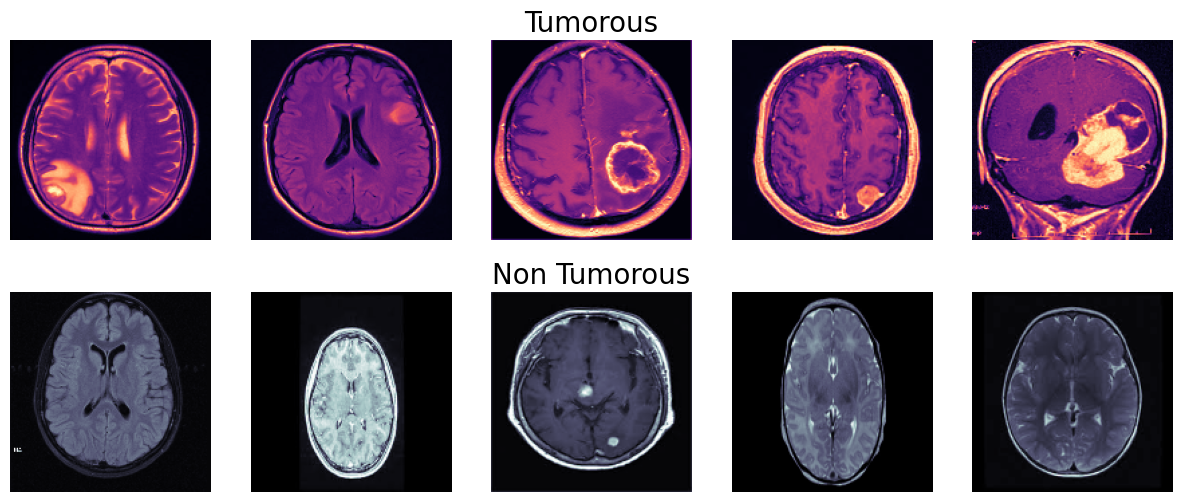

In [94]:
def load_images_from_folder(folder, num_images=5):
    images = []
    filenames = os.listdir(folder)[:num_images]
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)
    return images

# Loading images
tumor_images = load_images_from_folder(tumor_dir, 5)
no_tumor_images = load_images_from_folder(no_tumor_dir, 5)

# Plotting
fig, axes = plt.subplots(2, 5, figsize=(15,6))

for i in range(5):
    axes[0, i].imshow(tumor_images[i], cmap='magma')
    axes[0, i].axis('off')
    if i == 2:
        axes[0, i].set_title('Tumorous', fontsize=20)

    axes[1, i].imshow(no_tumor_images[i], cmap='bone')
    axes[1, i].axis('off')
    if i == 2:
        axes[1, i].set_title('Non Tumorous', fontsize=20)


# **Building CNN model**

In [68]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [96]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='binary',
    subset='validation',
    shuffle=False
)

def preprocess_input_vgg(x):
    return tf.image.grayscale_to_rgb(x)

# Create the base model with weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze base model layers to prevent training them initially
for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # binary classification

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS
)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 10s/step - accuracy: 0.3945 - loss: 0.9228 - val_accuracy: 0.6200 - val_loss: 0.7201
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 57s 8s/step - accuracy: 0.6628 - loss: 0.6863 - val_accuracy: 0.7000 - val_loss: 0.5971
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 59s 8s/step - accuracy: 0.6541 - loss: 0.5988 - val_accuracy: 0.7200 - val_loss: 0.5748
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 9s/step - accuracy: 0.7367 - loss: 0.5753 - val_accuracy: 0.7800 - val_loss: 0.4991
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 67s 10s/step - accuracy: 0.6679 - loss: 0.5850 - val_accuracy: 0.7800 - val_loss: 0.4729
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 60s 9s/step - accuracy: 0.7836 - loss: 0.4808 - val_accuracy: 0.8000 - val_loss: 0.4582
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 57s 8s/step - accuracy: 0.8157 - loss: 0.4300 - val_accuracy: 0.7800 - val_loss: 0.4363
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 67s 10s/step 

In [107]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

Final Training Accuracy: 96.04%
Final Validation Accuracy: 84.31%


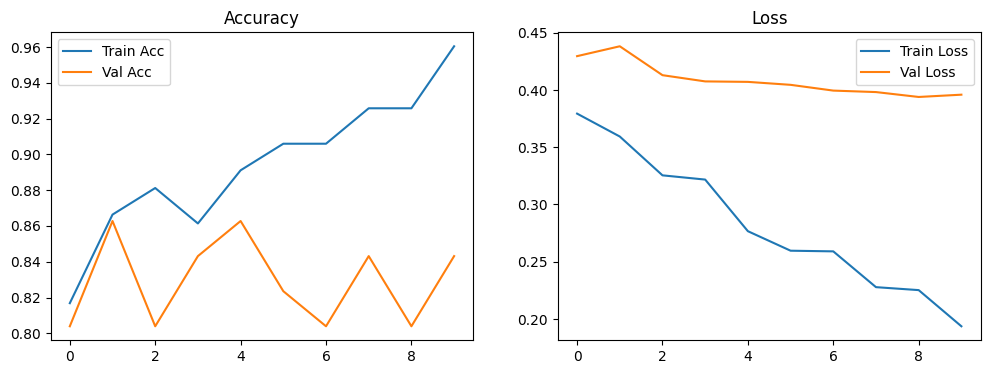

In [108]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()
